# **Importing the Modules, libraries**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# Loading the Dataset

In [2]:
data = pd.read_csv("/content/drive/MyDrive/All Station Data/Updataedhouly.csv")
data.head()

,Date,Precipitation,Air Temperature,Relative Humidity,Wind Speed
0,2019-11-11 06:00,0.0,23.4,69.4,2.4
1,2019-11-11 07:00,0.0,24.3,64.7,2.5
2,2019-11-11 08:00,0.0,25.0,59.3,2.5
3,2019-11-11 09:00,0.0,25.4,57.5,2.4
4,2019-11-11 10:00,0.0,24.8,60.4,2.3


In [3]:
data.columns

Index(['Date', ' Precipitation', 'Air Temperature', 'Relative Humidity',
       'Wind Speed '],
      dtype='object')

In [4]:
data.isnull().sum()

Date                 0
 Precipitation       0
Air Temperature      0
Relative Humidity    0
Wind Speed           0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26209 entries, 0 to 26208
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               26209 non-null  object 
 1    Precipitation     26209 non-null  float64
 2   Air Temperature    26209 non-null  float64
 3   Relative Humidity  26209 non-null  float64
 4   Wind Speed         26209 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1023.9+ KB


In [6]:
data.describe()

,Precipitation,Air Temperature,Relative Humidity,Wind Speed
count,26209.000000,26209.000000,26209.000000,26209.000000
mean,0.550109,20.270237,83.947697,1.491677
std,3.036524,6.309490,19.182829,0.712763
min,0.000000,3.500000,30.000000,0.000000
25%,0.000000,15.600000,70.600000,1.000000
50%,0.000000,21.600000,93.000000,1.400000
75%,0.000000,24.500000,100.000000,1.900000
max,45.000000,37.200000,100.000000,8.000000


# Correlation Between Variables

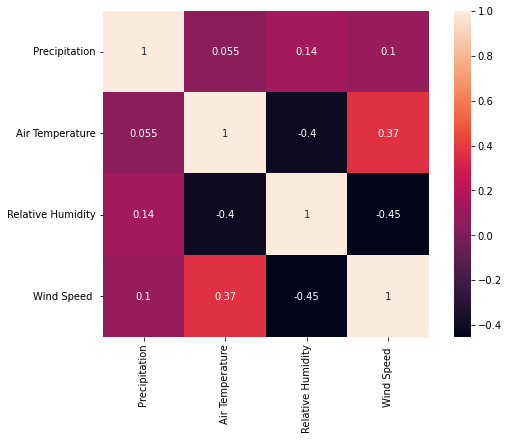

In [7]:
# heat map of correlation of features
correlation_matrix = data.corr()
fig = plt.figure(figsize=(9,6))
sns.heatmap(correlation_matrix,vmax=1,square = True, annot= True)
plt.show()

In [8]:
train_dates=pd.to_datetime(data['Date'])

In [9]:
cols = list(data)[1:5]

In [10]:
data_for_training= data[cols].astype(float)

# Scaling the Dataset/Normalization using MinMaxScaler

In [11]:
scaler=StandardScaler()
scaler.fit(data_for_training)
data_scaled=scaler.transform(data_for_training)

In [12]:
data_scaled[:10]

array([[-0.18116741,  0.49605003, -0.75838524,  1.27439249],
       [-0.18116741,  0.63869502, -1.00340069,  1.41469416],
       [-0.18116741,  0.74964113, -1.28490781,  1.41469416],
       [-0.18116741,  0.8130389 , -1.37874352,  1.27439249],
       [-0.18116741,  0.71794224, -1.22756377,  1.13409082],
       [-0.18116741,  0.48020059, -0.81051618,  0.29228079],
       [-0.18116741,  0.29000726, -0.17451862, -0.40922757],
       [-0.18116741,  0.22660949, -0.17973171, -0.54952925],
       [-0.18116741,  0.13151283,  0.04964446, -0.97043426],
       [-0.18116741, -0.04283105,  0.57095394, -1.25103761]])

# **Data preparation for Windowing**

In [13]:
'''X=[]
y=[]
#This is the no of predictions that we want our model predicts in future.
n_future=1
#This is number of data that we send to the model  for 1-window
n_past=22'''

'X=[]\ny=[]\n#This is the no of predictions that we want our model predicts in future.\nn_future=1\n#This is number of data that we send to the model  for 1-window\nn_past=22'

In [14]:
# multi-step data preparation
from numpy import array
def split_sequence(data_scaled, n_past, n_future):
  X, y = list(), list()
  for i in range(len(data_scaled)):
# find the end of this pattern
    end_ix = i + n_past
    out_end_ix = end_ix + n_future
# check if we are beyond the sequence
    if out_end_ix > len(data_scaled):
      break
# gather input and output parts of the pattern
    seq_x, seq_y = data_scaled[i:end_ix,0:4], data_scaled[end_ix:out_end_ix,1]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)
# choose a number of time steps
n_past, n_future = 24, 2
# split into samples
X, y = split_sequence(data_scaled, n_past, n_future)




In [15]:
X,y=np.array(X), np.array(y)

In [16]:
#DATA
X.shape, y.shape

((26184, 24, 4), (26184, 2))

In [17]:
X[:2]

array([[[-0.18116741,  0.49605003, -0.75838524,  1.27439249],
        [-0.18116741,  0.63869502, -1.00340069,  1.41469416],
        [-0.18116741,  0.74964113, -1.28490781,  1.41469416],
        [-0.18116741,  0.8130389 , -1.37874352,  1.27439249],
        [-0.18116741,  0.71794224, -1.22756377,  1.13409082],
        [-0.18116741,  0.48020059, -0.81051618,  0.29228079],
        [-0.18116741,  0.29000726, -0.17451862, -0.40922757],
        [-0.18116741,  0.22660949, -0.17973171, -0.54952925],
        [-0.18116741,  0.13151283,  0.04964446, -0.97043426],
        [-0.18116741, -0.04283105,  0.57095394, -1.25103761],
        [-0.18116741, -0.15377716,  0.83682178, -0.40922757],
        [-0.18116741, -0.20132549,  0.83682178, -0.54952925],
        [-0.18116741, -0.31227159,  0.83682178, -0.68983092],
        [-0.18116741, -0.40736825,  0.83682178, -0.83013259],
        [-0.18116741, -0.45491659,  0.83682178, -1.39133928],
        [-0.18116741, -0.39151881,  0.83682178, -1.25103761],
        

In [18]:
y[1]

array([0.62284558, 0.73379169])

In [19]:
'''#appending the arrays in windows
for i in range(n_past, len(data_scaled)-n_future+1):
  X.append(data_scaled[i-n_past:i,0:data_scaled.shape[1]])
  y.append(data_scaled[i+n_future-1:i+n_future,0])'''

'#appending the arrays in windows\nfor i in range(n_past, len(data_scaled)-n_future+1):\n  X.append(data_scaled[i-n_past:i,0:data_scaled.shape[1]])\n  y.append(data_scaled[i+n_future-1:i+n_future,0])'

In [20]:
#printing the shape:
print("The Training data i.e X shape: {}." .format(X.shape))
print("The result data  i.w y shape: {}." .format(y.shape))

The Training data i.e X shape: (26184, 24, 4).
The result data  i.w y shape: (26184, 2).


In [21]:
X[4002:4003]

array([[[ 0.41162691, -0.48661547,  0.77947773, -0.54952925],
        [ 2.12414385, -0.58171213,  0.83682178, -0.12862423],
        [-0.11530137, -0.35981992,  0.83682178,  1.13409082],
        [-0.18116741,  0.09981394, -0.04940434, -0.83013259],
        [-0.18116741,  0.30585671, -0.22664957,  0.57288413],
        [-0.18116741,  0.35340504, -0.15887933,  1.83559918],
        [-0.18116741,  0.36925448, -0.24750194,  2.67740921],
        [-0.18116741,  0.25830838, -0.18494481,  2.11620252],
        [-0.18116741,  0.38510393, -0.36219003,  0.99378915],
        [-0.18116741,  0.67039391, -1.24841615,  0.57288413],
        [-0.18116741,  0.76549057, -1.42566137,  0.29228079],
        [-0.18116741,  0.76549057, -1.27448162,  0.85348747],
        [-0.18116741,  0.57529725, -0.93563046, -0.12862423],
        [-0.18116741,  0.43265226, -0.50294359, -0.68983092],
        [-0.18116741,  0.13151283,  0.38849562,  0.15197911],
        [-0.18116741, -0.01113216,  0.7117075 ,  0.7131858 ],
        

In [22]:

y[3998:4002]

array([[-0.26472326, -0.23302438],
       [-0.23302438, -0.37566937],
       [-0.37566937, -0.50246492],
       [-0.50246492, -0.51831436]])

In [23]:
# Split the data into training, validation, and test sets
num_samples = X.shape[0]
training_samples = int(np.round(num_samples * 0.7))
validation_samples = int(np.round(num_samples * 0.15))
test_samples = num_samples - training_samples - validation_samples

X_train = X[:training_samples,:]
y_train = y[:training_samples]

X_val = X[training_samples:training_samples+validation_samples,:]
y_val = y[training_samples:training_samples+validation_samples]

X_test = X[training_samples+validation_samples:,:]
y_test = y[training_samples+validation_samples:]
 

In [24]:
#shapes of training, validation and test dataset:
X_train.shape,y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape

((18329, 24, 4),
 (18329, 2),
 (3928, 24, 4),
 (3928, 2),
 (3927, 24, 4),
 (3927, 2))

In [25]:
#Modeling 
model = Sequential()
model.add(LSTM(64, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='linear'))

In [26]:
#check Points of model for the saving the model
cp= ModelCheckpoint('model/Tempmodel.h5', best_model_only=True)

In [27]:
#Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss = 'mean_squared_error', 
              metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            17664     
                                                                 
 dropout (Dropout)           (None, 24, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 30,146
Trainable params: 30,146
Non-trainable params: 0
_________________________________________________________________


In [28]:
#Fit the model with training data
model.fit(X_train, y_train, epochs=20,batch_size=64, validation_data=(X_val,y_val), callbacks=[cp])

Epoch 1/20
287/287 [==============================] - 25s 65ms/step - loss: 0.1999 - accuracy: 0.6113 - val_loss: 0.0653 - val_accuracy: 0.7795
Epoch 2/20
287/287 [==============================] - 12s 41ms/step - loss: 0.0825 - accuracy: 0.7040 - val_loss: 0.0470 - val_accuracy: 0.8096
Epoch 3/20
287/287 [==============================] - 12s 41ms/step - loss: 0.0679 - accuracy: 0.7419 - val_loss: 0.0520 - val_accuracy: 0.8557
Epoch 4/20
287/287 [==============================] - 12s 41ms/step - loss: 0.0592 - accuracy: 0.7572 - val_loss: 0.0398 - val_accuracy: 0.8304
Epoch 5/20
287/287 [==============================] - 11s 37ms/step - loss: 0.0552 - accuracy: 0.7640 - val_loss: 0.0384 - val_accuracy: 0.7928
Epoch 6/20
287/287 [==============================] - 11s 39ms/step - loss: 0.0540 - accuracy: 0.7627 - val_loss: 0.0359 - val_accuracy: 0.8376
Epoch 7/20
287/287 [==============================] - 12s 41ms/step - loss: 0.0522 - accuracy: 0.7621 - val_loss: 0.0386 - val_accuracy:

In [29]:
#Importing the Best model
from tensorflow.keras.models import load_model
model=load_model('model/Tempmodel.h5')

#Training Accuracy

In [30]:
#changing to the 1d to compare the result
y_train1d=y_train.flatten()

In [31]:
y_train1d[:5]

array([0.48020059, 0.62284558, 0.62284558, 0.73379169, 0.73379169])

In [32]:
#Testing the training accuracy
train_predictions=model.predict(X_train).flatten()
train_results=pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals': y_train1d})
train_results

573/573 [==============================] - 5s 8ms/step


,Train Predictions,Actuals
0,0.518338,0.480201
1,0.724635,0.622846
2,0.726787,0.622846
3,0.853001,0.733792
4,0.721144,0.733792
...,...,...
36653,-1.812004,-1.928915
36654,-1.809702,-1.928915
36655,-1.861403,-1.992313
36656,-1.878021,-1.992313


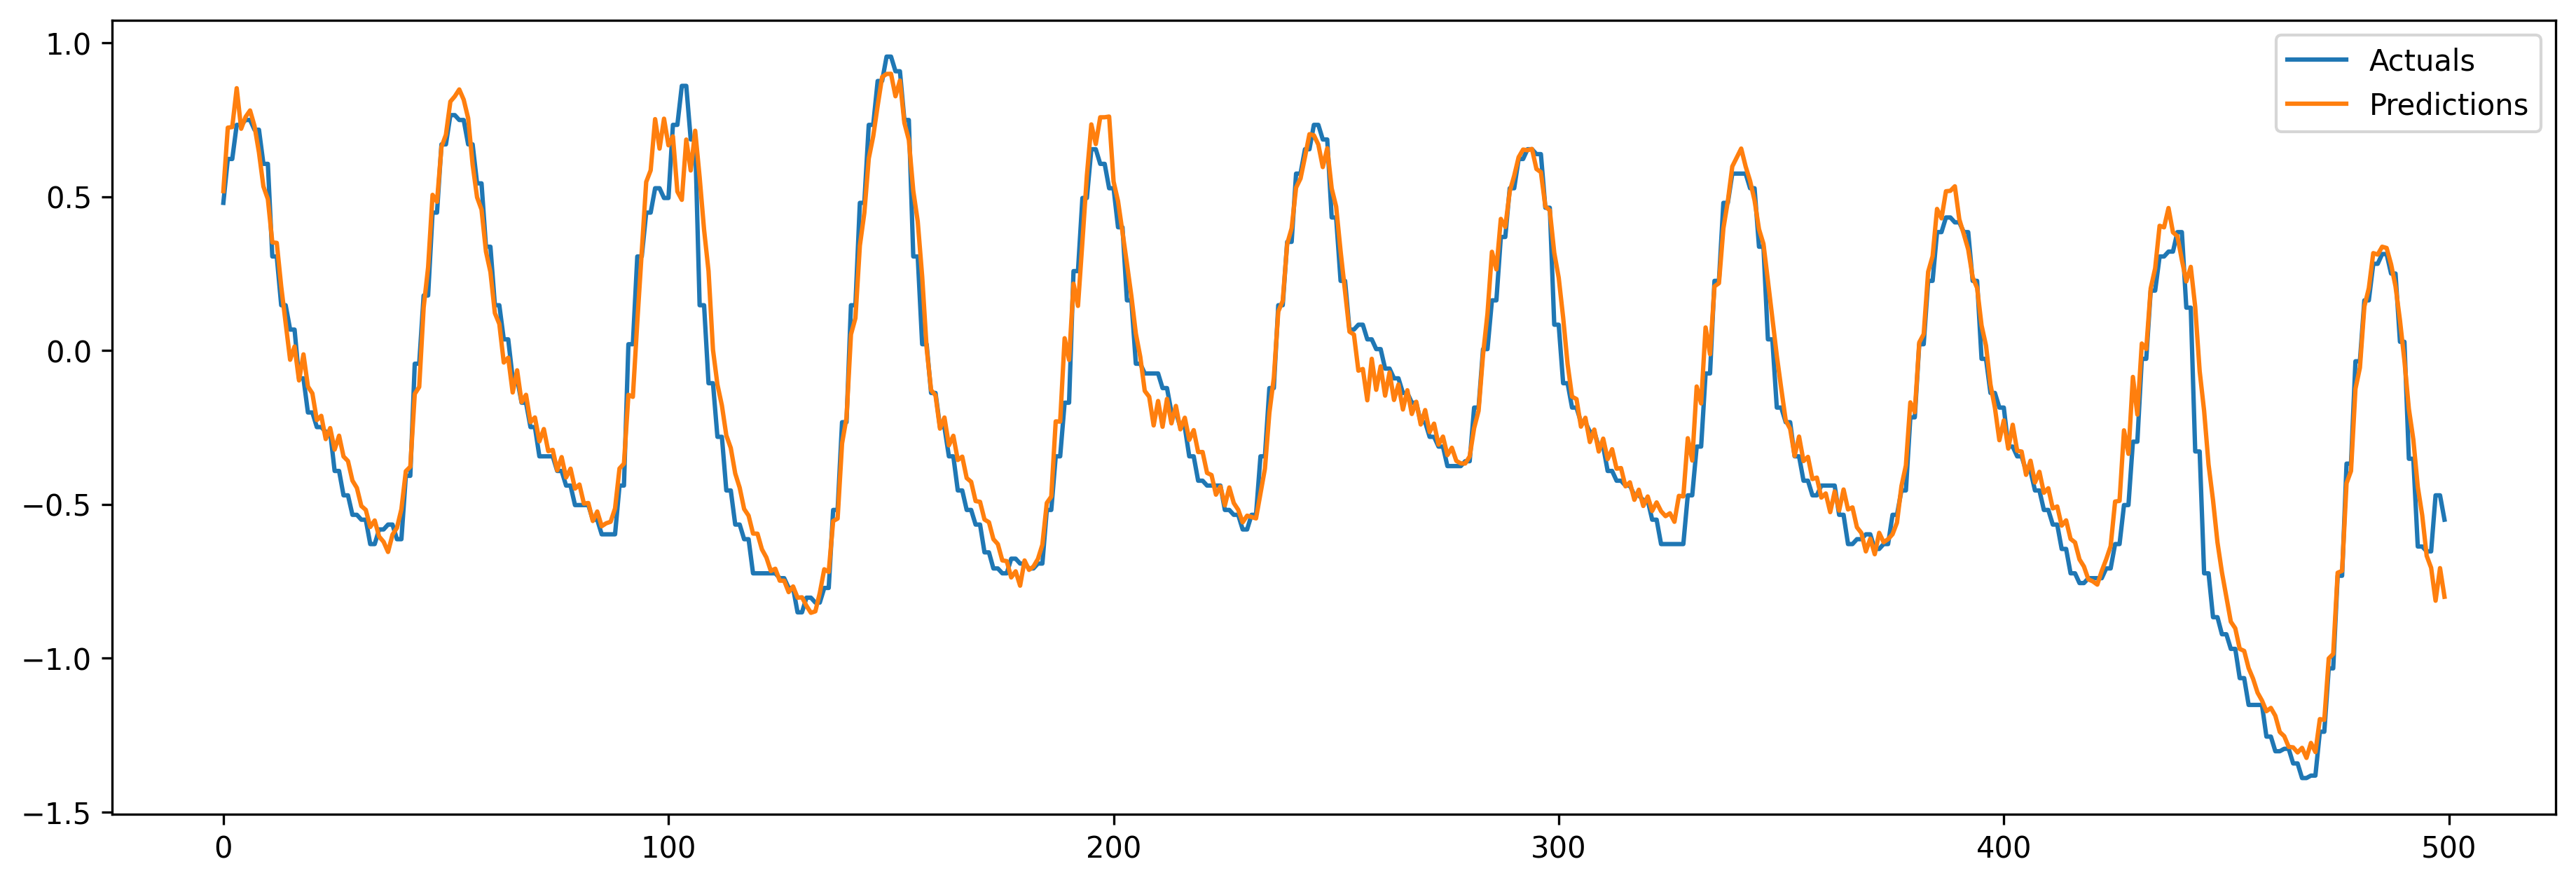

In [33]:
#plotting the training results:
plt.figure(figsize=(15,5), dpi=300)
# Create a plot
plt.plot(y_train1d[:500], label='Actuals')
plt.plot(train_predictions[0:500], label='Predictions')

# Add a legend
plt.legend()

# Show the plot
plt.show()


#Testing Accuracy

In [34]:
#changing the test data into 1d array
y_test1d=y_test.flatten()

In [37]:
#Testing the Test data  accuracy
test_predictions=model.predict(X_test).flatten()
test_results=pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals': y_test1d})
test_results

123/123 [==============================] - 2s 19ms/step


,Test Predictions,Actuals
0,0.158654,0.147362
1,0.088029,0.099814
2,0.110176,0.099814
3,0.045841,0.115663
4,0.085291,0.115663
...,...,...
7849,-0.224001,-0.137928
7850,-0.161628,-0.137928
7851,0.135405,0.194911
7852,0.198952,0.194911


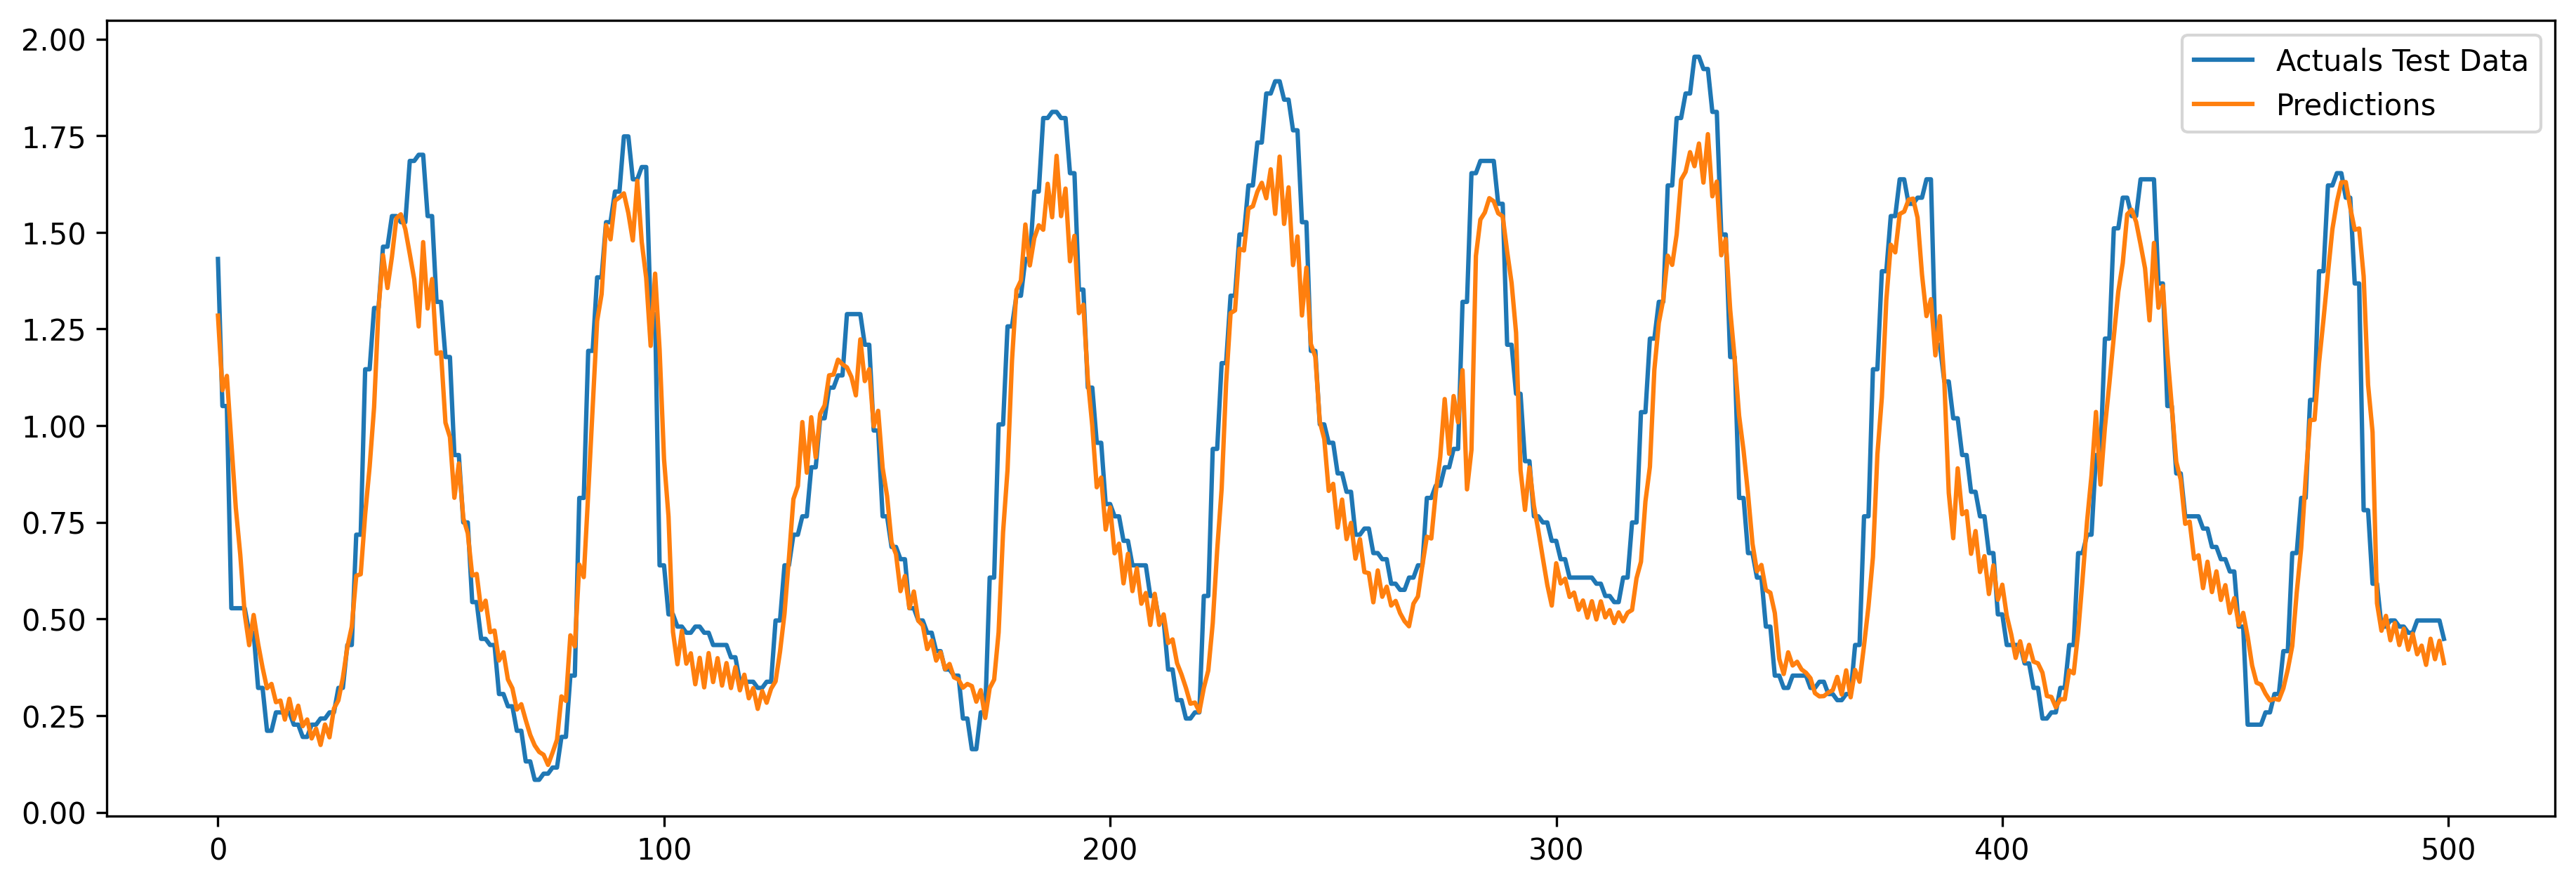

In [40]:
#plotting the testing results:
plt.figure(figsize=(15,5), dpi=300)
# Create a plot
plt.plot(y_test1d[1000:1500], label='Actuals Test Data')
plt.plot(test_predictions[1000:1500], label='Predictions')

# Add a legend
plt.legend()

# Show the plot
plt.show()


#**BiDirectional LSTM**

In [67]:
#Modeling 
model1 = Sequential()
model1.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True ), input_shape=(X_train.shape[1],X_train.shape[2])))
model1.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True)))
model1.add(Bidirectional(LSTM(50,activation='relu')))
model1.add(Dense(y_train.shape[1], activation='linear'))

In [68]:
#check Points of model for the saving the model
cp1= ModelCheckpoint('model1/Tempmodel1.h5', best_model_only=True)

In [69]:
#Compile the Model
model1.compile(optimizer=Adam(learning_rate=0.001), loss = 'mean_squared_error',metrics='accuracy')

In [72]:
model1.fit(X_train,y_train, epochs=20, validation_data=(X_val,y_val), batch_size=64, callbacks=[cp1])

Epoch 1/20
287/287 [==============================] - 37s 128ms/step - loss: 0.0913 - accuracy: 0.7625 - val_loss: 0.0680 - val_accuracy: 0.7989
Epoch 2/20
287/287 [==============================] - 33s 114ms/step - loss: 0.0427 - accuracy: 0.7821 - val_loss: 0.0480 - val_accuracy: 0.8315
Epoch 3/20
287/287 [==============================] - 33s 114ms/step - loss: 0.0333 - accuracy: 0.8020 - val_loss: 0.0393 - val_accuracy: 0.8322
Epoch 4/20
287/287 [==============================] - 34s 118ms/step - loss: 0.0278 - accuracy: 0.8170 - val_loss: 0.0355 - val_accuracy: 0.8103
Epoch 5/20
287/287 [==============================] - 32s 113ms/step - loss: 0.0250 - accuracy: 0.8221 - val_loss: 0.0333 - val_accuracy: 0.8539
Epoch 6/20
287/287 [==============================] - 33s 114ms/step - loss: 0.0233 - accuracy: 0.8263 - val_loss: 0.0320 - val_accuracy: 0.8521
Epoch 7/20
287/287 [==============================] - 34s 119ms/step - loss: 0.0220 - accuracy: 0.8310 - val_loss: 0.0307 - val_ac

In [74]:
#Importing the Best model
from tensorflow.keras.models import load_model
model1=load_model('model1/Tempmodel1.h5')

In [75]:
#Testing the training accuracy
train_predictions=model1.predict(X_train).flatten()
train_results=pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals': y_train1d})
train_results

573/573 [==============================] - 14s 21ms/step


,Train Predictions,Actuals
0,0.516122,0.480201
1,0.810912,0.622846
2,0.657296,0.622846
3,0.855618,0.733792
4,0.636670,0.733792
...,...,...
36653,-1.913717,-1.928915
36654,-1.938452,-1.928915
36655,-1.977424,-1.992313
36656,-2.035369,-1.992313


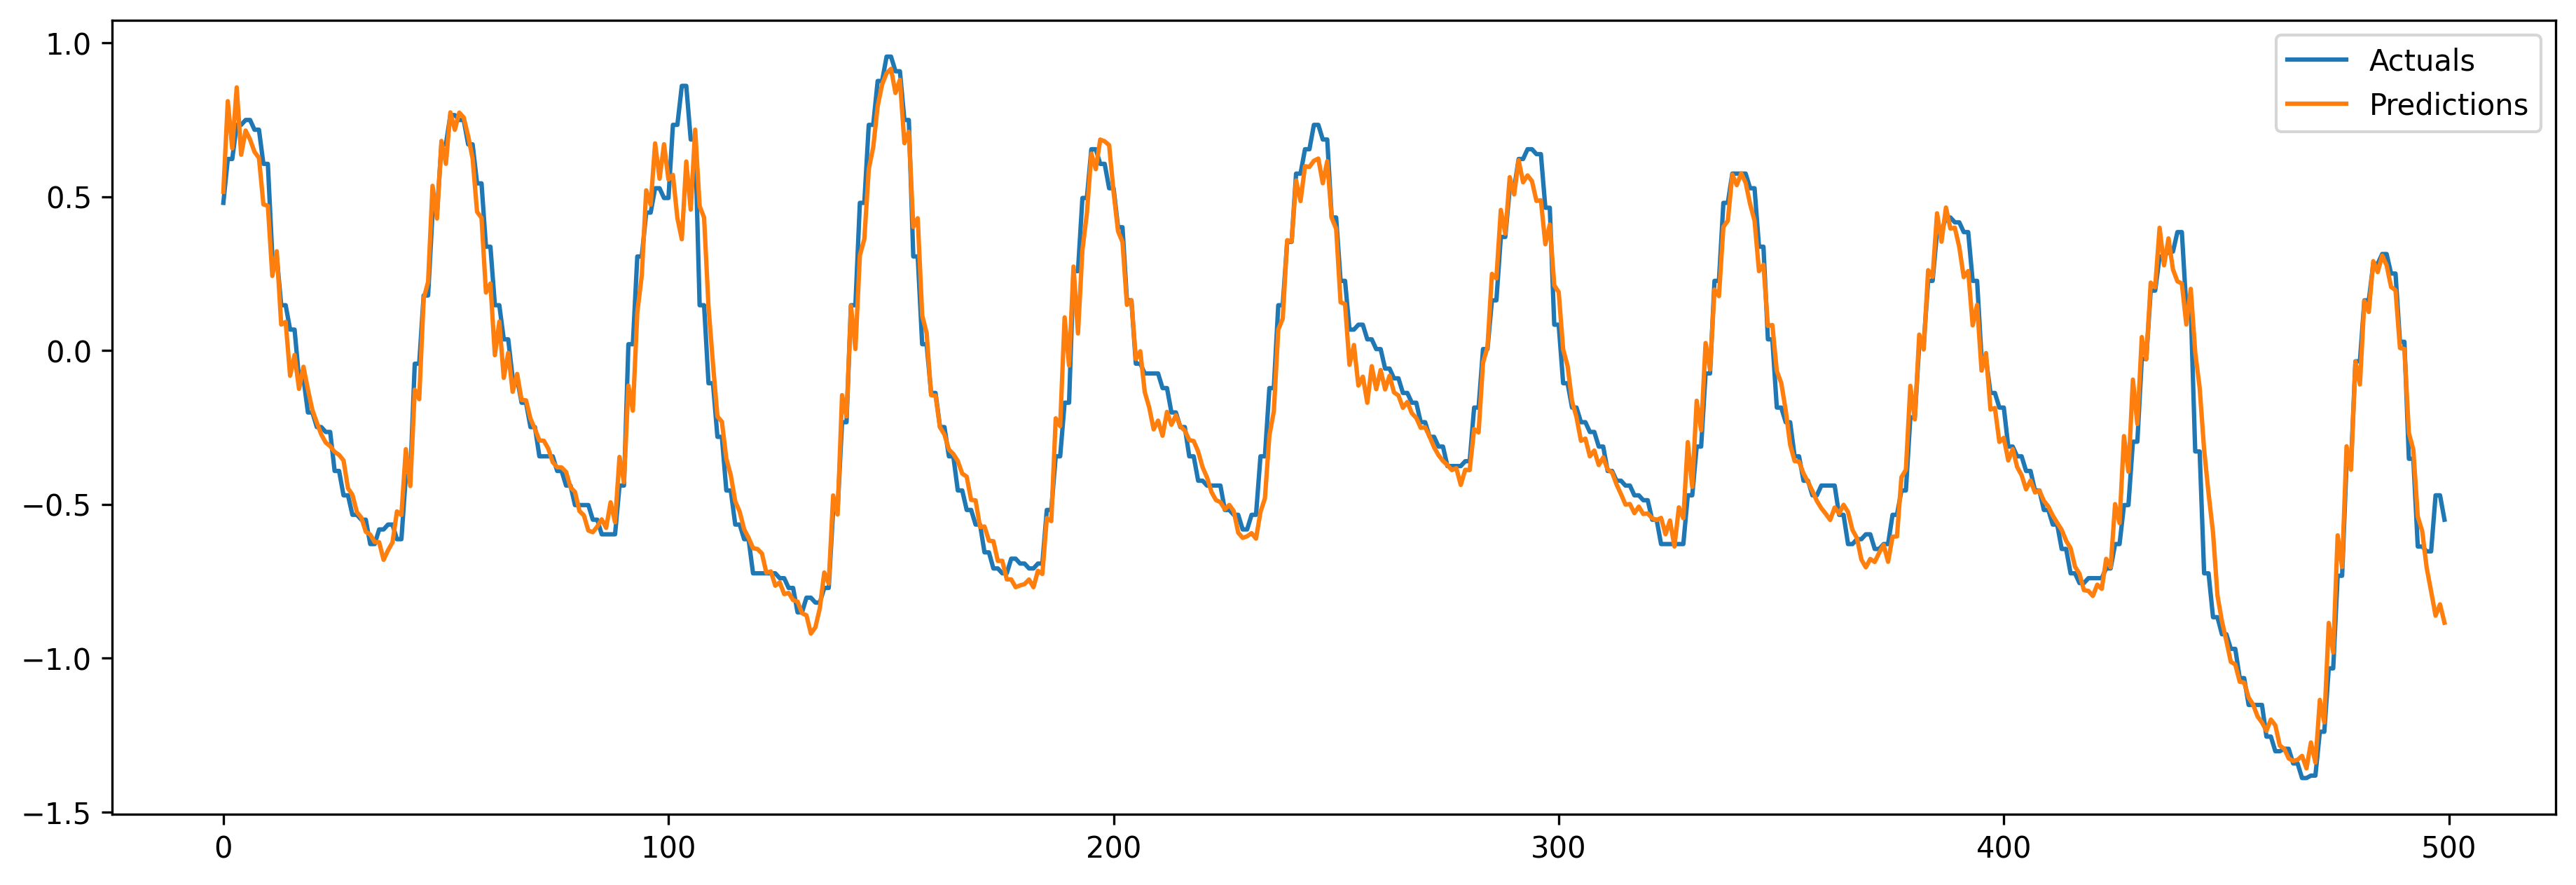

In [76]:
#plotting the training results:
plt.figure(figsize=(15,5), dpi=300)
# Create a plot
plt.plot(y_train1d[:500], label='Actuals')
plt.plot(train_predictions[0:500], label='Predictions')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [77]:
#Testing the Test data  accuracy
test_predictions=model1.predict(X_test).flatten()
test_results=pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals': y_test1d})
test_results

123/123 [==============================] - 2s 19ms/step


,Test Predictions,Actuals
0,0.136654,0.147362
1,0.100581,0.099814
2,0.077454,0.099814
3,0.037047,0.115663
4,0.035069,0.115663
...,...,...
7849,-0.160376,-0.137928
7850,-0.140373,-0.137928
7851,0.233725,0.194911
7852,0.154872,0.194911


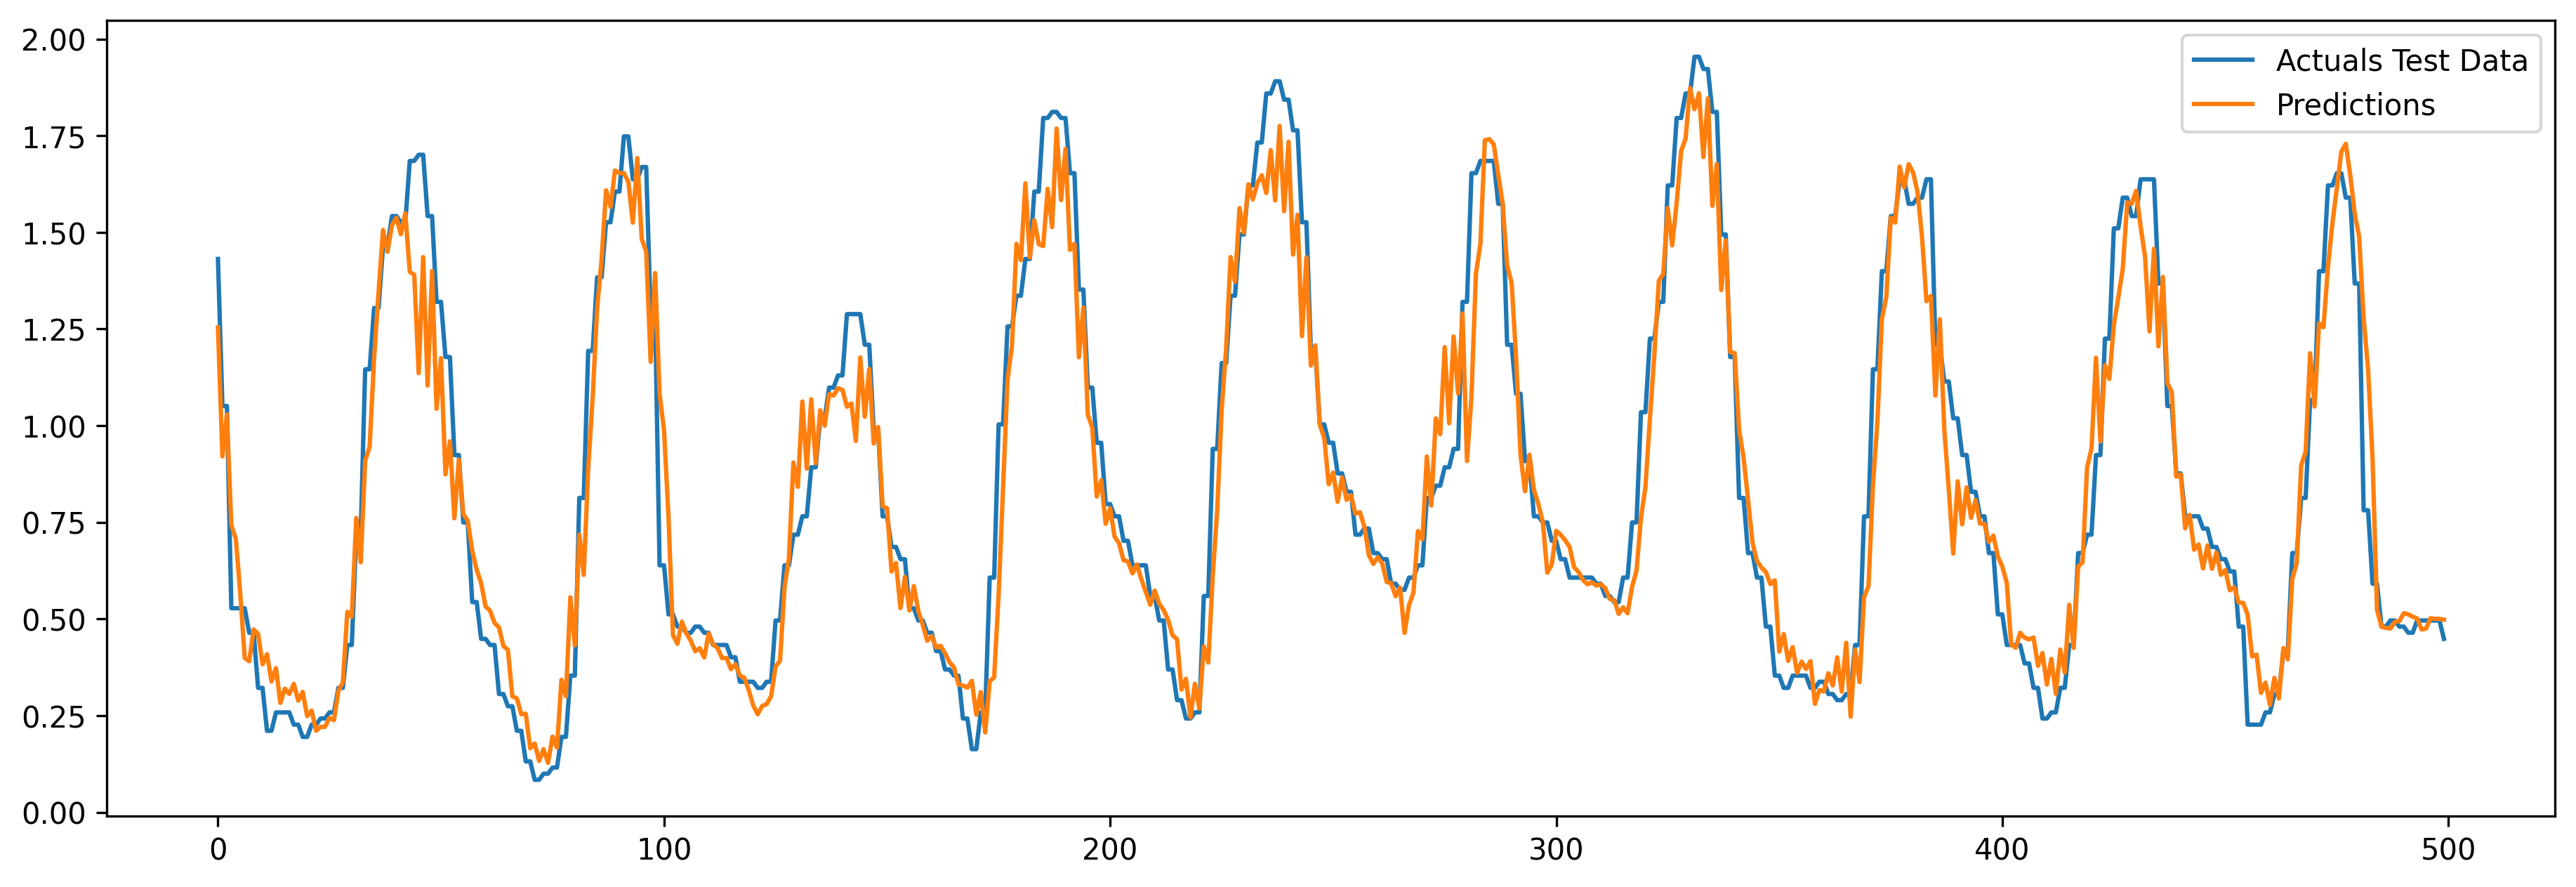

In [78]:
#plotting the testing results:
plt.figure(figsize=(15,5), dpi=300)
# Create a plot
plt.plot(y_test1d[1000:1500], label='Actuals Test Data')
plt.plot(test_predictions[1000:1500], label='Predictions')

# Add a legend
plt.legend()

# Show the plot
plt.show()
